In [27]:
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
from collections import defaultdict
import csv

# -------------------------
# Load YOLOv8 pose model
# -------------------------
model = YOLO("/home/debasish/Documents/YOLOv8/weights/pose-weights/yolov8x-832.pt")

# -------------------------
# Input/Output setup
# -------------------------
input_path = "/home/debasish/Documents/YOLOv8/image054.mp4"  # single video or folder
output_base_dir = Path("outputs/omega_turns")
output_base_dir.mkdir(parents=True, exist_ok=True)
VIDEO_EXTS = [".mp4", ".avi", ".mkv", ".mov"]

# -------------------------
# Create run subfolder
# -------------------------
def create_run_folder(base_dir):
    run_id = 1
    while (base_dir / f"run{run_id}").exists():
        run_id += 1
    run_dir = base_dir / f"run{run_id}"
    run_dir.mkdir(parents=True, exist_ok=True)
    return run_dir

# -------------------------
# Angle Calculation
# -------------------------
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians * 180 / np.pi)
    if angle > 180.0:
        angle = 360.0 - angle
    return angle

# -------------------------
# Process a single video
# -------------------------
def process_video(video_path, run_dir):
    video_name = Path(video_path).stem
    output_path = run_dir / f"{video_name}_omega.mp4"
    summary_path = run_dir / f"{video_name}_omega_counted.txt"
    framewise_csv = run_dir / f"{video_name}_framewise_turns.csv"

    cap = cv2.VideoCapture(str(video_path))
    width, height = int(cap.get(3)), int(cap.get(4))
    fps = round(cap.get(cv2.CAP_PROP_FPS)) or 30

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    frame_count = 0

    # Track worm data
    omega_frames = defaultdict(int)   # number of frames in omega posture
    omega_turns = defaultdict(int)    # number of completed omega turns
    last_state = defaultdict(lambda: "no_omega")
    all_worm_ids = set()

    # Color generator
    colors = {}
    def get_color(worm_id):
        if worm_id not in colors:
            np.random.seed(int(worm_id))
            colors[worm_id] = tuple(np.random.randint(0, 255, 3).tolist())
        return colors[worm_id]

    # Run YOLOv8 tracker
    results_gen = model.track(str(video_path), persist=True, tracker="bytetrack.yaml")

    # Store framewise data
    framewise_data = []

    for results in results_gen:
        frame_count += 1
        frame = results.orig_img.copy()
        current_frame_data = {}

        for result in results:
            if result.keypoints is None or result.boxes is None or result.boxes.id is None:
                continue

            track_id = int(result.boxes.id.cpu().numpy()[0])
            all_worm_ids.add(track_id)
            kpts = result.keypoints.xy.cpu().numpy()[0]
            if len(kpts) < 11:
                continue

            head, mid, tail = kpts[1], kpts[5], kpts[9]
            angle = calculate_angle(head, mid, tail)

            # Determine omega posture
            omega_flag = 1 if angle < 60 else 0
            if omega_flag == 1:
                omega_frames[track_id] += 1

            # Detect transitions for counting omega turns
            if omega_flag == 1 and last_state[track_id] == "no_omega":
                omega_turns[track_id] += 1
                last_state[track_id] = "omega"
            elif omega_flag == 0:
                last_state[track_id] = "no_omega"

            current_frame_data[track_id] = omega_flag

            # Draw skeleton and overlay info
            color = get_color(track_id)
            cv2.line(frame, tuple(head.astype(int)), tuple(mid.astype(int)), color, 2)
            cv2.line(frame, tuple(mid.astype(int)), tuple(tail.astype(int)), color, 2)

            info_text = f"ID:{track_id} ang:{int(angle)} turns:{omega_turns[track_id]}"
            text_x, text_y = int(mid[0]) + 10, int(mid[1]) - 10
            cv2.putText(frame, info_text, (text_x, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

        framewise_data.append(current_frame_data)
        out.write(frame)

    cap.release()
    out.release()

    # -------------------------
    # Write framewise binary table
    # -------------------------
    all_worm_ids = sorted(list(all_worm_ids))
    with open(framewise_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        header = ["frame"] + [f"worm_{wid}" for wid in all_worm_ids]
        writer.writerow(header)

        for i, frame_data in enumerate(framewise_data, start=1):
            row = [i]
            for wid in all_worm_ids:
                row.append(frame_data.get(wid, 0))
            writer.writerow(row)

    # -------------------------
    # Save summary
    # -------------------------
    with open(summary_path, "w") as f:
        for wid in all_worm_ids:
            total_frames = omega_frames[wid]
            total_turns = omega_turns[wid]
            f.write(f"Worm {wid}: {total_turns}\n")

    print(f"[INFO] Processed: {video_name}")
    print(f"[INFO] Saved video: {output_path}")
    print(f"[INFO] Summary: {summary_path}")
    print(f"[INFO] Framewise CSV: {framewise_csv}")

# -------------------------
# Run on single file or folder
# -------------------------
input_path = Path(input_path)

if input_path.is_file() and input_path.suffix.lower() in VIDEO_EXTS:
    run_dir = create_run_folder(output_base_dir)
    process_video(input_path, run_dir)

elif input_path.is_dir():
    videos = [f for f in input_path.iterdir() if f.suffix.lower() in VIDEO_EXTS]
    for v in videos:
        run_dir = create_run_folder(output_base_dir)
        process_video(v, run_dir)
else:
    print(f"[ERROR] No valid video found at {input_path}")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/3048) /home/debasish/Documents/YOLOv8/image054.mp4: 640x832 8 worms, 23.6ms
video 1/1 (frame 2/3048) /home/debasish/Documents/YOLOv8/image054.mp4: 640x832 8 worms, 25.2ms
video 1/1 (frame 3/3048) /home/debasish/Documents/YOLOv8/image054.mp4: 640x832 8 worms, 25.2ms
video 1/1 (frame 4/3048) /home/debasish/Documents/YOLOv8/image054.mp4: 640x832 8 worms, 24.6ms
video 1/1 (frame 5/3048) /home/debasish/Documents/YOLOv8/image054.mp4: 640x8

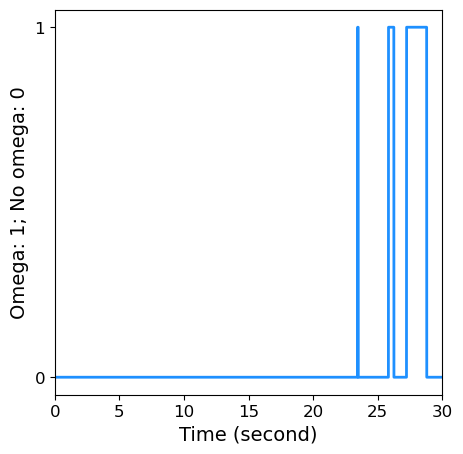

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/home/debasish/Documents/YOLOv8/outputs/omega_turns/run2/image003_framewise_turns.csv")
frame = df['frame'].to_list()
turns = df['worm_1'].to_list()

plt.figure(figsize=(5,5))
time = np.linspace(0,30.45,3045)

plt.plot(time, turns, color = 'dodgerblue', linewidth=2)
plt.xlim(0,30)
plt.xlabel('Time (second)',fontsize=14)
plt.ylabel('Omega: 1; No omega: 0', fontsize=14)
plt.yticks([0, 1])
plt.tick_params(axis='both', labelsize=12)
plt.show()